In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import scipy.linalg as linalg
import numpy as np
import scipy as scp

# Apply BFN on noisy linear systems

We will carry out the excersize on the following equation
$$ \frac{\mathrm{d} x}{\mathrm{d} t}= Ax, x\in \mathbb{R}^{2}$$



In [2]:
#rhs of the differential eq
def solve_eq(vec, pars):
  dvec= pars@vec.T
  return dvec
# equation to solve the differential eq back in time
def solve_eq_backwards(vec, pars, dt):
  A= (np.eye(pars.shape[0]))- dt*pars
  A_inv= np.linalg.inv(A)
  dvec= A_inv@pars@vec
  return dvec
# integrate the equation with the known true initial x
def generate_true(xin, time, pars):
  frhs = xin*0.0
  store_vec= []
  
  vec= xin
  for t in range(1, len(time)):
    store_vec.append(vec)
    dvec= pars@vec.T
    dt= time[t]-time[t-1]
    # print(np.array(dt*dvec)[0]); print(type(dt*dvec))
    vec= vec + np.array(dt*dvec)[0]
  store_vec.append(vec)

  return np.array(store_vec)

You can find details for the forward and backward nudging equations in the report.

In [3]:
def nudge_forward(xin, time, pars, K, y_obs, H):

  store_vec= []
  # a, b, d, g = pars
  # x, y = xin
  vec= xin
  for t in range(1, len(time)):
    store_vec.append(vec)
    gain_vec= K*(y_obs[t].T- H@vec.T)
    dvec= solve_eq(vec, pars) + gain_vec
    dt= time[t]-time[t-1]
    # print(dt*dvec)
    vec= vec + np.array(dt*dvec)[0]
  store_vec.append(vec)

  return np.array(store_vec)

def nudge_backward(x_tilda, time, pars, K_prime, y_obs, H):

  store_vec= []
  vec= x_tilda.copy()
  
  for t in range(len(time)-1, 0, -1):
    store_vec.append(vec)
    gain_vec= K_prime*(y_obs[t].T- H@vec.T)
    dt= time[t]-time[t-1]
    dvec= solve_eq_backwards(vec, pars, dt) - gain_vec
  
    # print(dt*dvec)
    vec= vec - np.array(dt*dvec)[0]
  store_vec.append(vec)

  return np.flip(store_vec, axis=0)


def back_forth_nudge(pars, t, K, K_back, H, y_obs, number_of_iterations): #once
  store_backward, store_forward=[], []
  #tilta, normal
  xin= np.mean(y_obs, axis=0)
  nudge= nudge_forward(xin, t, pars, K, y_obs, H)
  store_forward.append(nudge)
  for it in range(number_of_iterations):
    nudge_back= nudge_backward(nudge[-1], t, pars, K_back, y_obs, H)
    nudge= nudge_forward(nudge_back[0], t, pars, K, y_obs, H)
    store_backward.append(nudge_back)
    store_forward.append(nudge)
  return store_forward, store_backward

In [4]:
def rmse(x, y):
    return np.sqrt(np.mean(np.square(x-y)))

def given_true_traj_rmse(xtraj, xtrue):
    
    rmse_x=rmse(xtraj[:,0], xtrue[:,0])
    rmse_y=rmse(xtraj[:,1], xtrue[:,1])
    
    
    rmse_v= np.array([rmse_x, rmse_y])
    return rmse_v

def given_true_traj_rmse_t(xtraj, xtrue):
    rmse_t=[]
    for i in range(len(xtraj)):
        rmse_v= rmse(xtraj, xtrue)
        rmse_t.append(rmse_v)
    return rmse_t

Generating the y_obs based on a fixed covariance matrix and observational operator.

Model parameters,
$$A=\begin{bmatrix}
2 &  0\\
0& 1 \\
\end{bmatrix}, H=\begin{bmatrix}
3 &  0\\
0& 3 \\
\end{bmatrix}, R=\begin{bmatrix}
4 &  1\\
1&  1\\
\end{bmatrix}$$

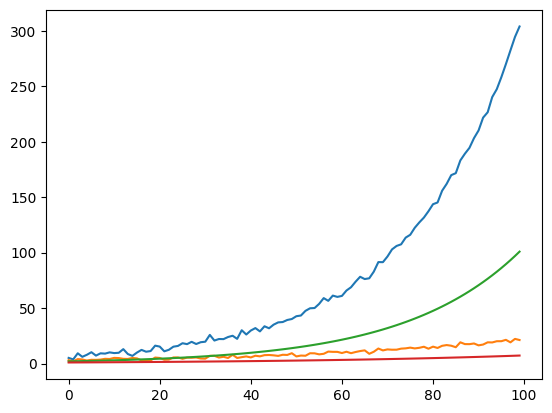

In [5]:


t = np.linspace(0,2,100)
xin= np.array([2.,1.])
pars= np.matrix([[2.,0.],[0.,1.]])
H= np.eye(2)*3


cov_obs= np.array([[4.,1.],[1.,1.]])
r = 1

xtrue= generate_true(xin, t, pars)

#generate
y_obs= xtrue*0.0
for i in range(len(t)):
    y_obs[i] = H.dot(xtrue[i]) + np.random.multivariate_normal(mean= [0,0], cov= cov_obs)
    
plt.plot(y_obs)
plt.plot(xtrue)

We take k=k'=2.0,
We have chosen our forward and backward gain matrices, as given in the paper,

$$K=kH^{T}, K'=k'H^{T}$$

In [6]:
K, K_back= 2,2
store_for, store_back=  back_forth_nudge(pars, t, K, K_back, H, y_obs, 10)

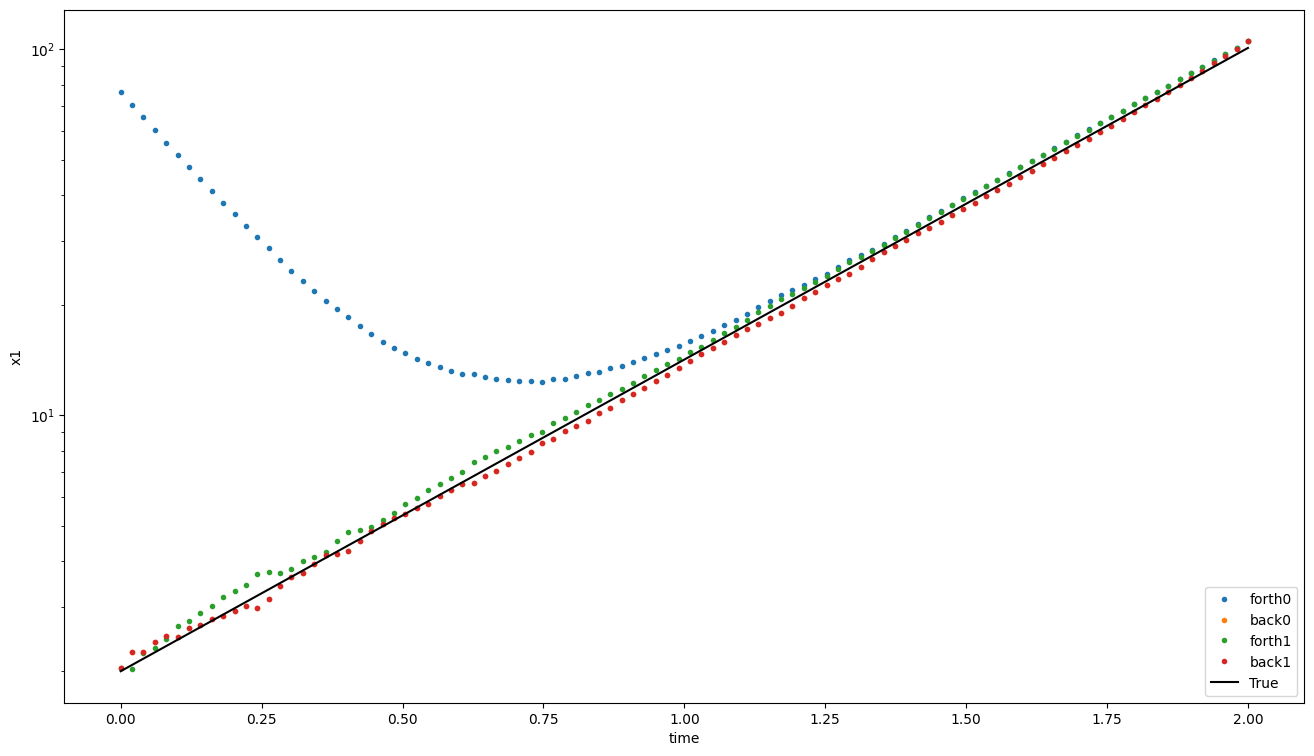

In [7]:
plt.figure(figsize=(16,9))
for it in range(2):
    plt.semilogy(t, store_for[it][:,0], ".", label= f"forth{it}")
    plt.semilogy(t, store_back[it][:,0], ".", label= f"back{it}")
plt.semilogy(t, xtrue[:,0], "-", label="True", color="black")
plt.xlabel("time"); plt.ylabel("x1")

plt.legend()

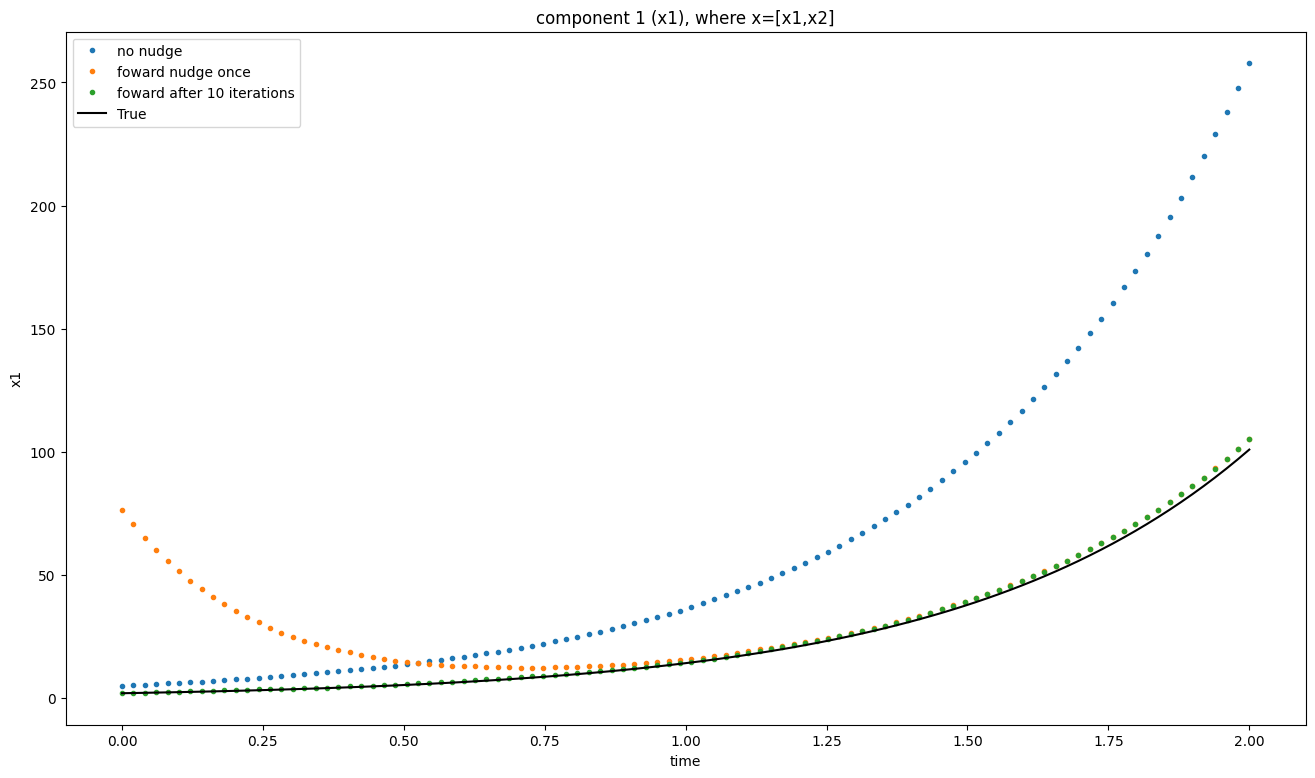

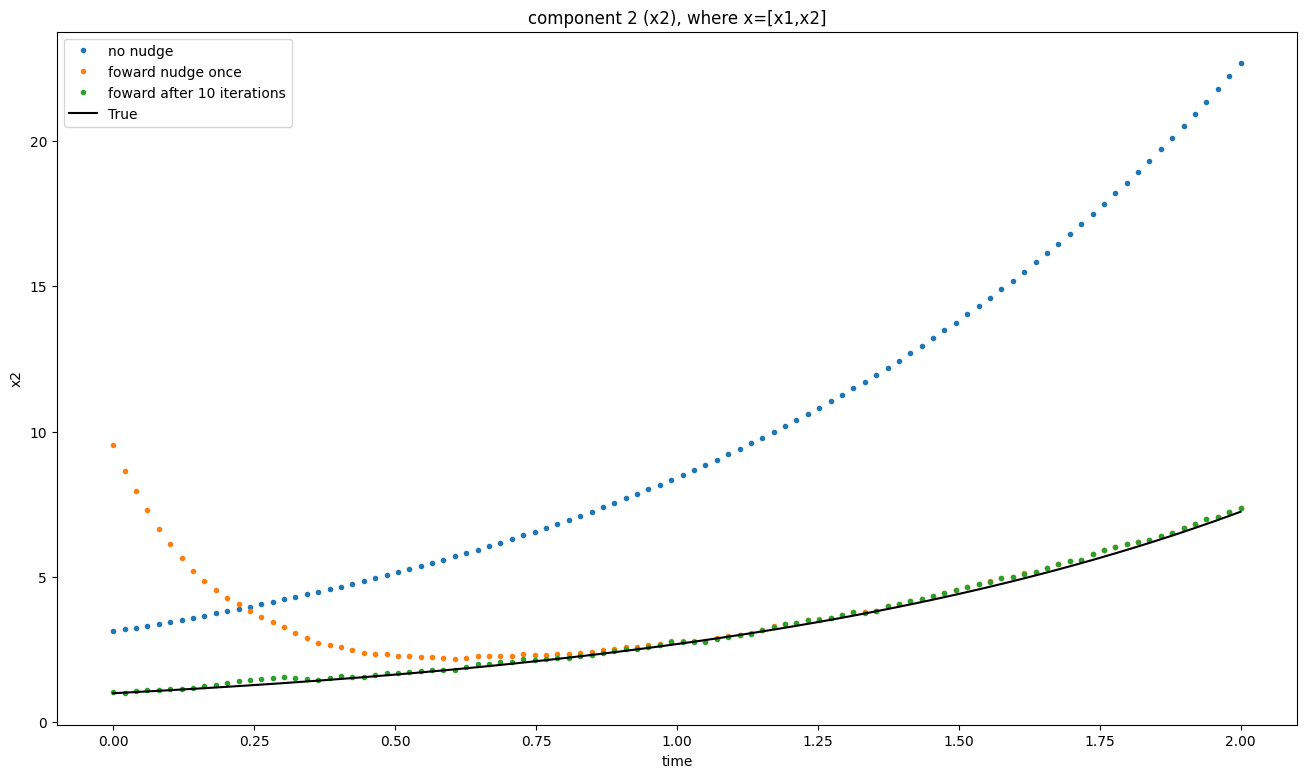

In [8]:
x_nonudge= generate_true(y_obs[0], t, pars)
plt.figure(figsize=(16,9))
it=-1

plt.plot(t, x_nonudge[:,0], ".", label="no nudge")
plt.plot(t, store_for[0][:,0], ".", label= f"foward nudge once")
plt.plot(t, store_for[it][:,0], ".", label= f"foward after 10 iterations")
plt.plot(t, xtrue[:,0], "-", label="True", color="black")

plt.xlabel("time"); plt.ylabel("x1")
plt.legend()
plt.title("component 1 (x1), where x=[x1,x2]")
plt.show()

plt.figure(figsize=(16,9))
it=-1

plt.plot(t, x_nonudge[:,1], ".", label="no nudge")
plt.plot(t, store_for[0][:,1], ".", label= f"foward nudge once")
plt.plot(t, store_for[it][:,1], ".", label= f"foward after 10 iterations")
plt.plot(t, xtrue[:,1], "-", label="True", color="black")

plt.xlabel("time"); plt.ylabel("x2")
plt.legend()
plt.title("component 2 (x2), where x=[x1,x2]")
plt.show()

Text(0, 0.5, 'rmse')

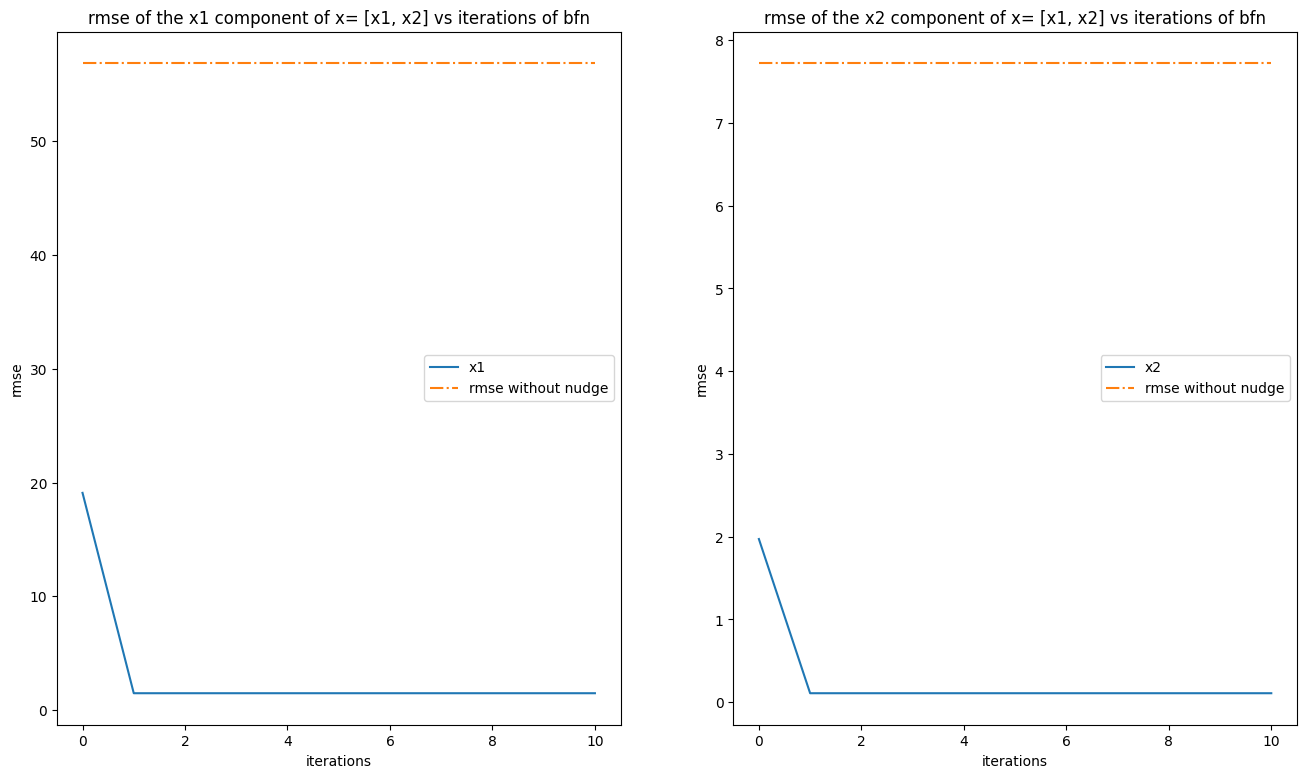

In [9]:
rmse_iter= np.array([given_true_traj_rmse(traj[:], xtrue[:]) for traj in store_for])
rmse_no_nudge= np.array([given_true_traj_rmse(x_nonudge[:], xtrue[:])] * len(rmse_iter))

plt.figure(figsize=(16,9))
plt.subplot(1,2,1)
plt.plot(rmse_iter[:,0], label="x1")
plt.plot(rmse_no_nudge[:,0], "-.",label="rmse without nudge")
plt.legend()
plt.title("rmse of the x1 component of x= [x1, x2] vs iterations of bfn")
plt.xlabel("iterations")
plt.ylabel("rmse")
# plt.show()
plt.subplot(1,2,2)
plt.plot(rmse_iter[:,1], label="x2")
plt.plot(rmse_no_nudge[:,1], "-.",label="rmse without nudge")
plt.legend()
plt.title("rmse of the x2 component of x= [x1, x2] vs iterations of bfn")
plt.xlabel("iterations")
plt.ylabel("rmse")

Model converges after 1 forward and 1 backward nudge!

# Effect of very large K and K'

In [12]:
K, K_back= 20,20
store_for, store_back=  back_forth_nudge(pars, t, K, K_back, H, y_obs, 10)

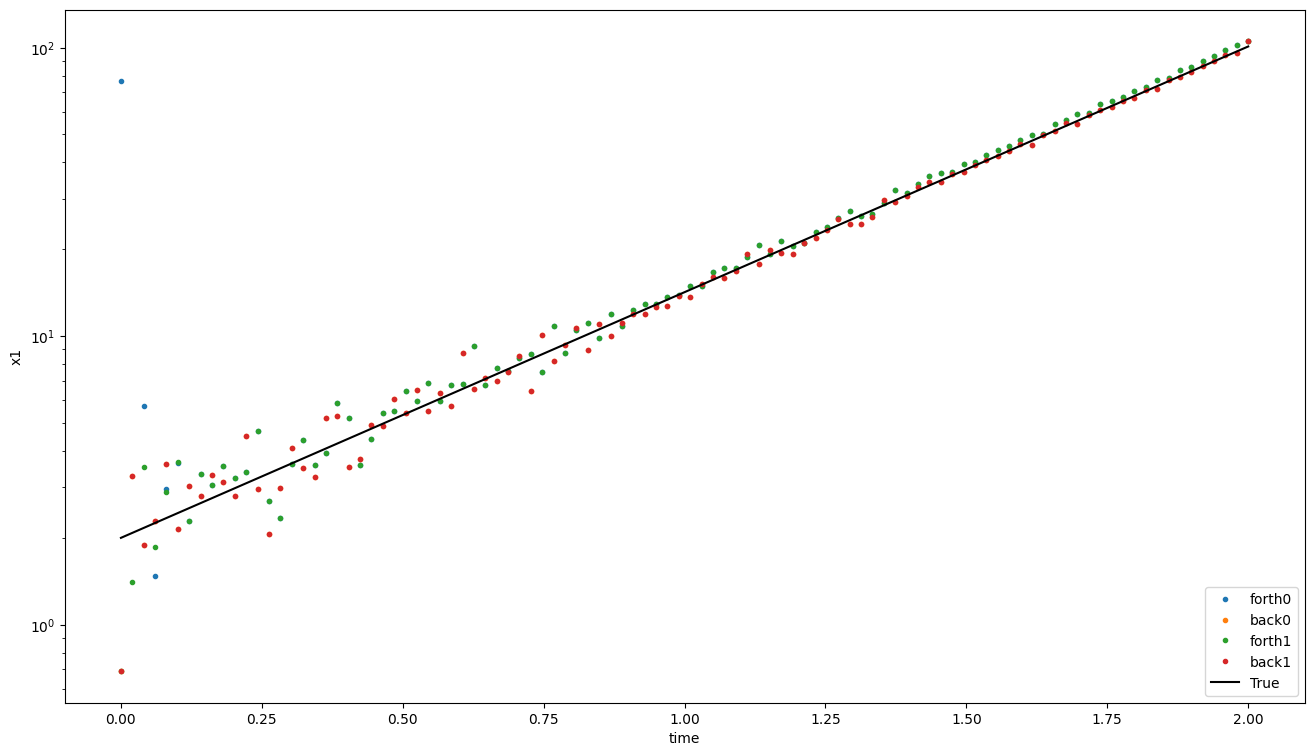

In [13]:
plt.figure(figsize=(16,9))
for it in range(2):
    plt.semilogy(t, store_for[it][:,0], ".", label= f"forth{it}")
    plt.semilogy(t, store_back[it][:,0], ".", label= f"back{it}")
plt.semilogy(t, xtrue[:,0], "-", label="True", color="black")
plt.xlabel("time"); plt.ylabel("x1")

plt.legend()

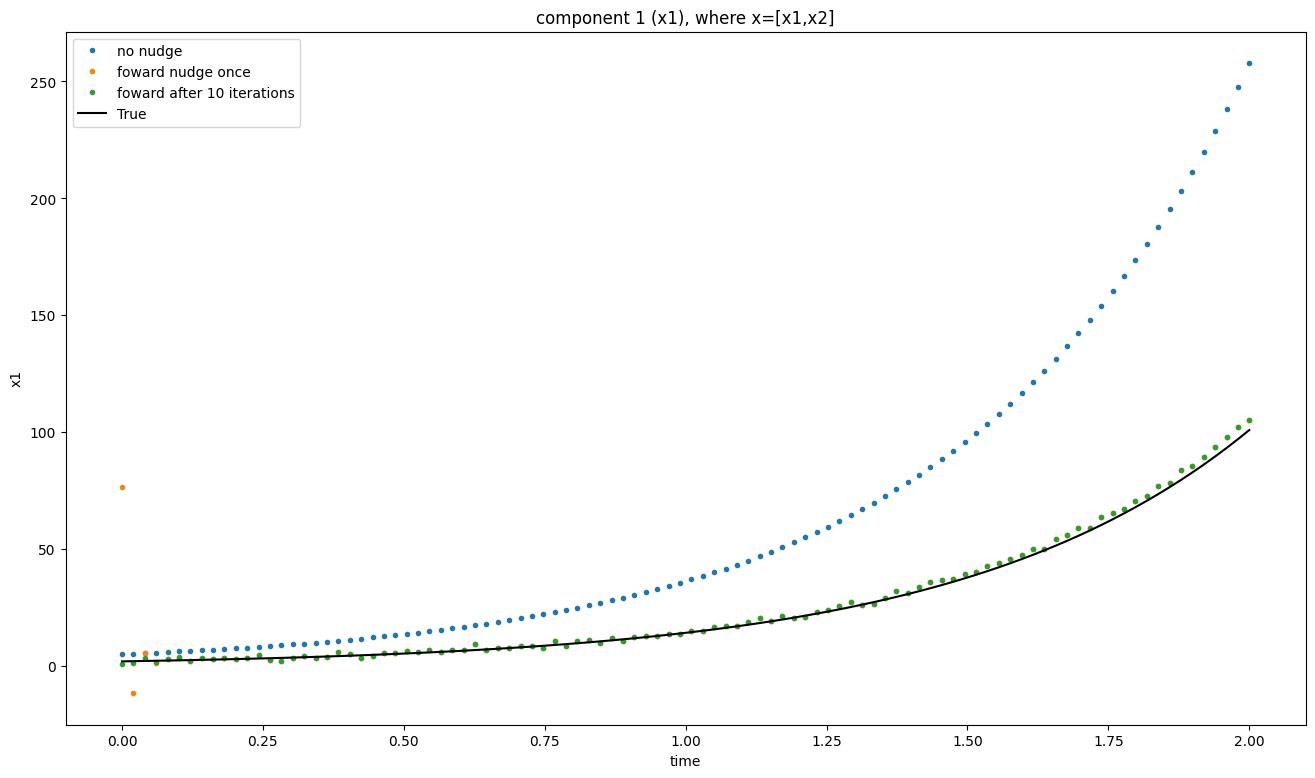

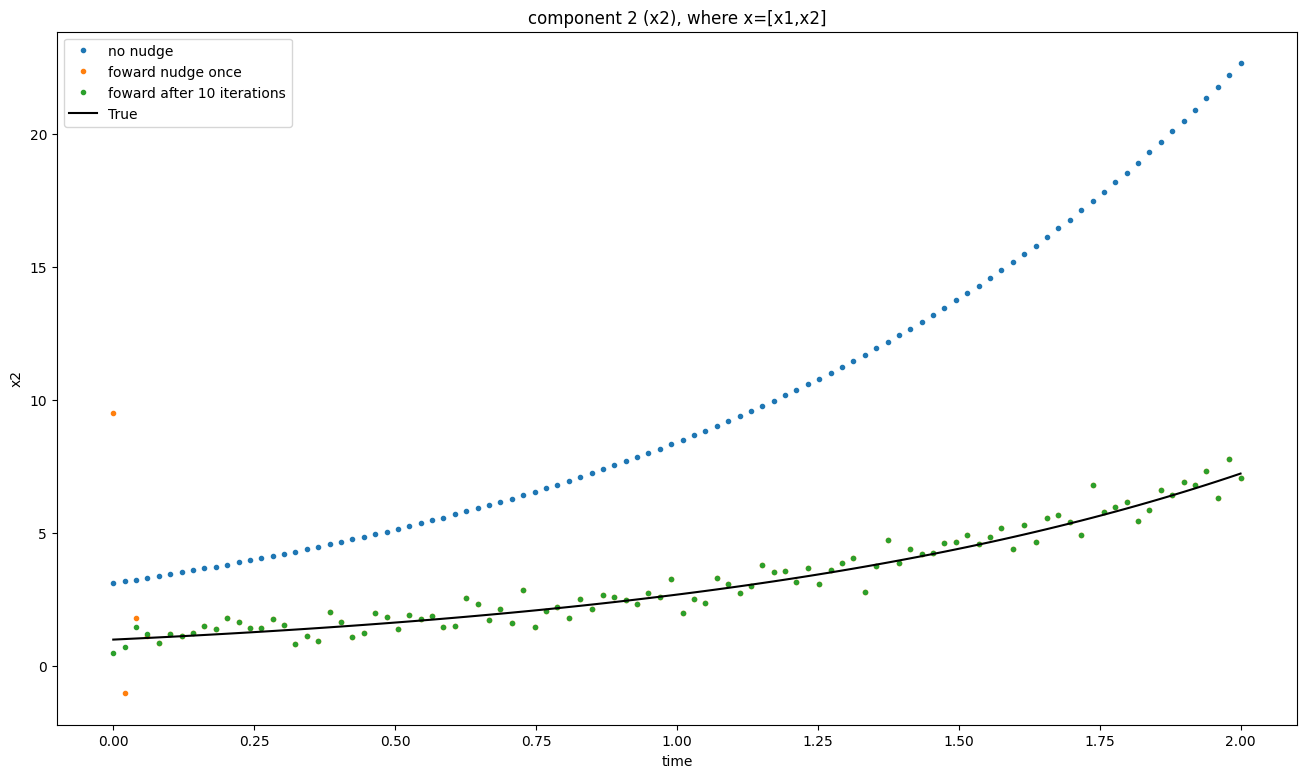

In [14]:
x_nonudge= generate_true(y_obs[0], t, pars)
plt.figure(figsize=(16,9))
it=-1

plt.plot(t, x_nonudge[:,0], ".", label="no nudge")
plt.plot(t, store_for[0][:,0], ".", label= f"foward nudge once")
plt.plot(t, store_for[it][:,0], ".", label= f"foward after 10 iterations")
plt.plot(t, xtrue[:,0], "-", label="True", color="black")

plt.xlabel("time"); plt.ylabel("x1")
plt.legend()
plt.title("component 1 (x1), where x=[x1,x2]")
plt.show()

plt.figure(figsize=(16,9))
it=-1

plt.plot(t, x_nonudge[:,1], ".", label="no nudge")
plt.plot(t, store_for[0][:,1], ".", label= f"foward nudge once")
plt.plot(t, store_for[it][:,1], ".", label= f"foward after 10 iterations")
plt.plot(t, xtrue[:,1], "-", label="True", color="black")

plt.xlabel("time"); plt.ylabel("x2")
plt.legend()
plt.title("component 2 (x2), where x=[x1,x2]")
plt.show()

Text(0, 0.5, 'rmse')

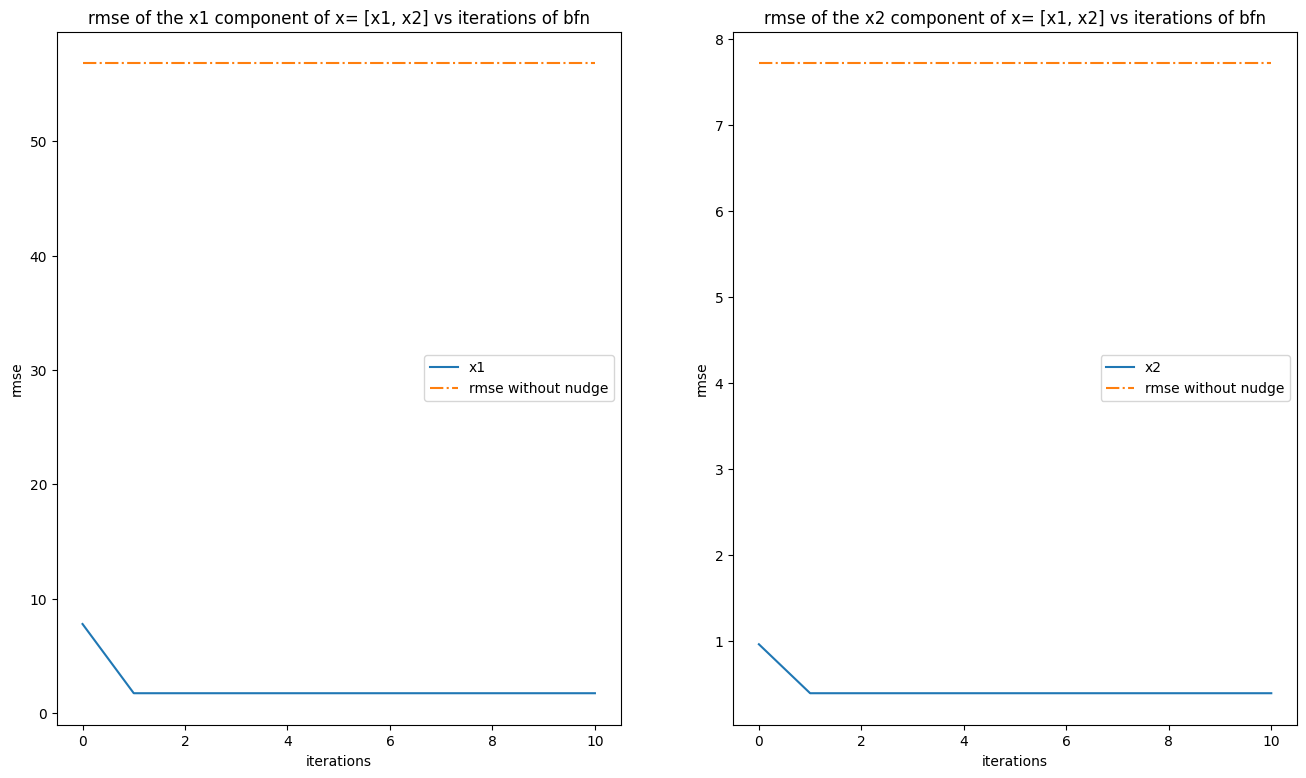

In [15]:
rmse_iter= np.array([given_true_traj_rmse(traj[:], xtrue[:]) for traj in store_for])
rmse_no_nudge= np.array([given_true_traj_rmse(x_nonudge[:], xtrue[:])] * len(rmse_iter))

plt.figure(figsize=(16,9))
plt.subplot(1,2,1)
plt.plot(rmse_iter[:,0], label="x1")
plt.plot(rmse_no_nudge[:,0], "-.",label="rmse without nudge")
plt.legend()
plt.title("rmse of the x1 component of x= [x1, x2] vs iterations of bfn")
plt.xlabel("iterations")
plt.ylabel("rmse")
# plt.show()
plt.subplot(1,2,2)
plt.plot(rmse_iter[:,1], label="x2")
plt.plot(rmse_no_nudge[:,1], "-.",label="rmse without nudge")
plt.legend()
plt.title("rmse of the x2 component of x= [x1, x2] vs iterations of bfn")
plt.xlabel("iterations")
plt.ylabel("rmse")

Larger k and k', lead to more "influence" of observations on your final output. This is why the final output is noisier and more spread out when k,k' are increased. 

BFN still coverges at low rmse but the output is just more "noiser".